In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from itertools import islice
import time
import matplotlib.pyplot as plt

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])  # преобразование данных
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

### LeNet

Точность без обучения: 8.90%
SGD:
Эпоха: 1, Потери: 0.07345247929538491
Эпоха: 2, Потери: 0.07175528088103988
Эпоха: 3, Потери: 0.053526434817039635
Эпоха: 4, Потери: 0.028173130331263105
Эпоха: 5, Потери: 0.015995335143639336
Точность SGD: 88.50%
Время обучения: 4.201862812042236 с

AdaDelta:
Эпоха: 1, Потери: 0.06018150577158816
Эпоха: 2, Потери: 0.021618540829686977
Эпоха: 3, Потери: 0.011500456678206478
Эпоха: 4, Потери: 0.008577917295414756
Эпоха: 5, Потери: 0.0064432480092496
Точность AdaDelta: 94.40%
Время обучения: 3.8968193531036377 с

NAG:
Эпоха: 1, Потери: 0.06801489484843923
Эпоха: 2, Потери: 0.029100338437918153
Эпоха: 3, Потери: 0.011983239558586942
Эпоха: 4, Потери: 0.010395273335897593
Эпоха: 5, Потери: 0.008072875452035272
Точность NAG: 89.00%
Время обучения: 3.9934427738189697 с

Adam:
Эпоха: 1, Потери: 0.04016878371680978
Эпоха: 2, Потери: 0.013632323505527684
Эпоха: 3, Потери: 0.007453220866636427
Эпоха: 4, Потери: 0.006953508980365704
Эпоха: 5, Потери: 0.0058102699

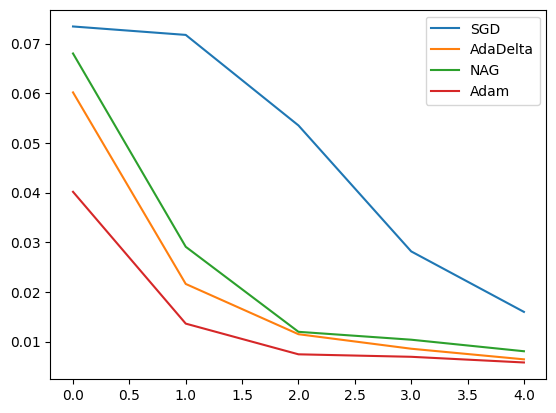

In [22]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = x.view(-1, 256)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net0 = LeNet()
net = LeNet()
criterion = nn.CrossEntropyLoss()

def resetNet():
    net.load_state_dict(net0.state_dict())

def countAccuracy():
    correct = 0
    size = 1000
    for image, label in islice(testset, size):
        outputs = net(image)
        _, predicted = torch.max(outputs.data, 1)
        correct += predicted == label
    return 100 * correct.item() / size#len(testset)

def train(optimizer, optim_name):
    print(f"{optim_name}:")
    start_time = time.time()
    xs, ys = [], []
    for epoch in range(5):
        running_loss = 0.0
        for inputs, labels in islice(trainloader, 30):
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        xs.append(epoch)
        ys.append(running_loss / len(trainloader))
        print(f'Эпоха: {epoch + 1}, Потери: {ys[-1]}')
    plt.plot(xs, ys, label = optim_name)
    print(f"Точность {optim_name}: {countAccuracy():.2f}%")
    print(f"Время обучения: {time.time() - start_time} с\n")

resetNet()
print(f"Точность без обучения: {countAccuracy():.2f}%")
SGD = optim.SGD(net.parameters(), lr=0.1)
train(SGD, "SGD")
resetNet()
AdaDelta = optim.Adadelta(net.parameters(), lr=1.0)
train(AdaDelta, "AdaDelta")
resetNet()
NAG = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, nesterov=True)
train(NAG, "NAG")
resetNet()
Adam = optim.Adam(net.parameters(), lr=0.005)
train(Adam, "Adam")

plt.legend()
plt.show()